In [ ]:
!pip install colormaps gdown
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.stats import kendalltau, pearsonr
import colormaps
import seaborn as sns

In [ ]:
# Constants
Lv = 2500840.0 # J/kg
cpd = 1004.666218 # J/K/kg

The following function is used to identify estimate the timing of onset in each year from the time series of L<sub>v</sub>P - OLR. Although this algorithm works well for the [South China Sea](https://doi.org/10.1029/2025GL118131), where the start of the wet season is especially sharp, it must be adjusted for the West African monsoon. I have made some small changes to the criteria to improve inter-dataset agreement and the "eye test" evaluation below, but I encourage you to think about each step and consider building a new algorithm from scratch.

In [ ]:
def onsetdate(ts, tsr10, thrsh=0, minmax=50, debug=False):
    mm = tsr10.values.argmax()
    # LvP - OLR must exceed threshold on onset date in both raw time series and slow annual cycle
    ix = np.where((ts.values > thrsh))[0].squeeze() #& (tsr10.values > thrsh))[0].squeeze()
    # Set minimum date?
    # ix = ix[ix > 20]
    # Identify local maxima (requires scipy)
    mx = argrelextrema(ts.values, np.greater)[0].squeeze()
    # Construct pairs of candidates and local maxima
    cnd = []
    for ii in ix:
        for pp in mx:
            if debug:
                print(ii, pp, ts.values[ii:pp+1])
            # Local maximum must be at or after the candidate
            if pp < ii: continue
            # Local maximum in LvP - OLR must exceed the critical value
            elif ts.values[pp] < minmax:
                if debug: print('Failed minmax')
                continue
            # All values of LvP - OLR between candidate date and later local maximum must exceed
            # value on candidate date
            elif np.any(ts.values[ii:pp+1] < ts.values[ii]):
                if debug: print('Failed ISV check')
                continue
            # Slow annual cycle (50-day rolling mean) must be consistently larger than
            # onset from onset to its maximum
            elif np.any(tsr10.values[ii:mm] - tsr10.values[ii] < 0):
                if debug: print('Failed AC check')
                continue
            else: cnd.append((ii,pp))
    if debug: print(cnd[0], max(cnd[0][0], 23))
    return cnd[0][0]

As in the previous notebook, read in the data and create time series averaged within 10°W to 10°E and 7°N to 17°N. In this case only OLR and precipitation are needed. Multiply the precipitation by the latent heat of vaporization (above) to get $L_vP$, the energy flux form of precipitation.

In [ ]:
# Observations
!gdown {'1LP_poS2Sc1bFlctqHIRh9j8h5vAK2gBH'}
!gdown {'1yBWSyR6p7b5mbFyYaw0Y5-iXTRhFxU0B'}

# Reanalysis precipitation and OLR
!gdown {'1RnNiv4iTdQDOZYz6RCa8YznbWpW5vrwa'}
!gdown {'1X4iEDqSARpF8mWxrt8r2Zb1wk1qVgq7n'}
!gdown {'1ailuu8awjReWTzithgdo38T0hTeZRW34'}
!gdown {'1ARbfGEGGnexMUUyRD1IqbneM6aaQQNFL'}

In [ ]:
obs = {}
# precipitation and OLR
# area averages

In [ ]:
# we need the time axis to be the same
obs['prc'].time.values[:] = obs['olr'].time.values[:]

In [ ]:
era5 = {}
# ERA5 precipitation and OLR
# area averages

In [ ]:
jra3q = {}
# JRA-3Q precipitation and OLR
# area averages

jra3q['prc'].time.values[:] = obs['prc'].time.values
jra3q['olr'].time.values[:] = jra3q['prc'].time.values

The following code computes onset dates for all twenty years included in the file. Change as needed, and then try it. Try out other thresholds and parameters. Can you find a suitable combination?

In [ ]:
obs['onset'] = []
thr = (obs['prc'] - obs['olr']).quantile(0.7).values
mmx = (obs['prc'] - obs['olr']).quantile(0.8).values
for yyyy in range(2001,2021):
    mtc = (obs['prc'] - obs['olr']).sel(time=str(yyyy))
    tsp = mtc.rolling(time=10, center=True, min_periods=1).mean('time')
    tsl = mtc.rolling(time=50, center=True, min_periods=1).mean('time')
    obs['onset'].append(onsetdate(tsp,tsl,thrsh=thr, minmax=mmx))

In [ ]:
df = {}
df['obs'] = pd.Series(obs['onset'])


In [ ]:
era5['onset'] = []
thr = (era5['prc'] - era5['olr']).quantile(0.7).values
mmx = (era5['prc'] - era5['olr']).quantile(0.8).values
for yyyy in range(2001,2021):
    mtc = (era5['prc'] - era5['olr']).sel(time=str(yyyy))
    tsp = mtc.rolling(time=10, center=True, min_periods=1).mean('time')
    tsl = mtc.rolling(time=50, center=True, min_periods=1).mean('time')
    era5['onset'].append(onsetdate(tsp,tsl,thrsh=thr, minmax=mmx))

df['era'] = pd.Series(era5['onset'])

In [ ]:
jra3q['onset'] = []
thr = (jra3q['prc'] - jra3q['olr']).quantile(0.7).values
mmx = (jra3q['prc'] - jra3q['olr']).quantile(0.8).values
for yyyy in range(2001,2021):
    mtc = (jra3q['prc'] - jra3q['olr']).sel(time=str(yyyy))
    tsp = mtc.rolling(time=10, center=True, min_periods=1).mean('time')
    tsl = mtc.rolling(time=50, center=True, min_periods=1).mean('time')
    jra3q['onset'].append(onsetdate(tsp,tsl,thrsh=thr, minmax=mmx))

df['jra'] = pd.Series(jra3q['onset'])
df = pd.DataFrame(df)

Print out summary statistics for onset based on these three datasets:

In [ ]:
df.describe()

The average identified onset dates based on my settings range from 17 June (based on CERES and IMERG) to 23 June (based on JRA-3Q). The latest onset date is 24 July (by JRA-3Q, in 2014), while the earliest is 1 May (by ERA5, remarkably also in 2014!). How sensitive are these results to changes in the thresholds or other parameters?

Overall, JRA-3Q provides a better match to day-to-day precipitation variability in IMERG than does ERA5. Although ERA5 provides a more realistic simulation of mean OLR, interannual variability in onset based on JRA-3Q is more consistent with that based on observations. OLR is less variable, and biases in OLR are more consistent in time. Because onset identification depends mainly on tracking changes in L<sub>v</sub>P - OLR, JRA-3Q appears to outperform ERA5 in this aspect.

In [ ]:
# Compute the cross-correlations
df.corr(method='kendall')

The following code plots figures year by year to illustrate interannual variability in the initial identified onset dates (vertical lines) relative to variations in precipitation (5-day rolling means). To make this useful, we would need to do much more testing and validation against ground truth (rather than only satellite observations).

In [ ]:
clrs = colormaps.srip_reanalysis.colors
years = list(range(2001,2021))
xtv = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
mns = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

for ii in range(len(years)):
    obsr = (86400*obs['prc']/Lv).sel(time=str(years[ii])).groupby('time.dayofyear').mean('time').rolling(dayofyear=5, center=True, min_periods=1).mean('dayofyear')
    (86400*era5['prc']/Lv).sel(time=str(years[ii])).groupby('time.dayofyear').mean('time').rolling(dayofyear=5, center=True, min_periods=1).mean('dayofyear').plot(color=clrs[2], label='ERA5')
    (86400*jra3q['prc']/Lv).sel(time=str(years[ii])).groupby('time.dayofyear').mean('time').rolling(dayofyear=5, center=True, min_periods=1).mean('dayofyear').plot(color=clrs[5], label='JRA-3Q')
    plt.gca().fill_between(obsr.dayofyear.values, 0, obsr.values, facecolor='#dddddd', edgecolor='#999999', zorder=0)
    plt.gca().axvline(obs['onset'][ii], color='#999999', zorder=0, lw=3)
    plt.gca().axvline(era5['onset'][ii], color=clrs[2])
    plt.gca().axvline(jra3q['onset'][ii], color=clrs[5])
    plt.gca().set_title(str(years[ii]))
    plt.gca().set_ylabel('Precipitation [mm/day]')
    plt.gca().set_ylim((0,12))
    plt.gca().set_xlim((0,365))
    plt.gca().legend(loc='upper left', frameon=False, bbox_to_anchor=[0, 0.95])
    for ii in range(len(xtv)-1):
        plt.gca().axvline(xtv[ii+1], color='#999', ls=':', lw=0.75, zorder=0)
        plt.gca().text((xtv[ii] + xtv[ii+1])/2, 11.8, mns[ii], ha='center', va='top', fontsize='small')
    plt.show()


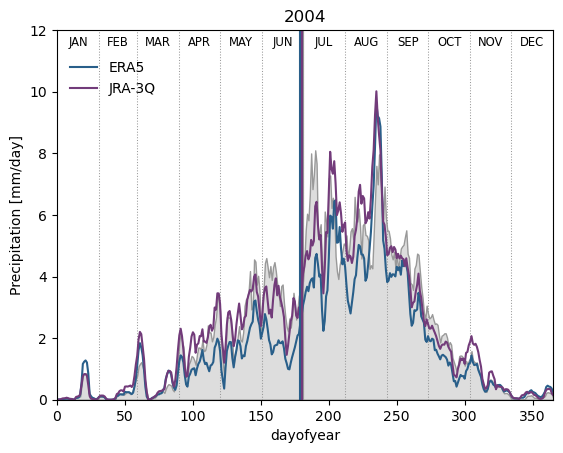

What could you do with this information?
- Labeling to build a model for prediction of onset timing
- Link the timing of onset to crop yields, water resources
- Risk of extreme events or heavy air pollution in the pre-monsoon period
- ...